In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

from scipy.stats import kstest

from sklearn.metrics import mean_squared_error
import math


In [3]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [4]:
from load_and_clean import *

update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

Unable to update Apple mobility data


These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'Canada-Quebec', 'China-Henan', 'Netherlands-Curacao', 'United Kingdom-Bermuda', 'Slovakia', 'Canada-Northwest Territories', 'Canada-Grand Princess', 'Saint Vincent and the Grenadines', 'United Kingdom-Channel Islands', 'Canada-Ontario', 'Australia-New South Wales', 'China-Jiangsu', 'China-Guizhou', 'France-Saint Barthelemy', 'China-Tianjin', 'Canada-Newfoundland and Labrador', 'Canada-New Brunswick', 'Australia-Tasmania', 'France-French Polynesia', 'United Kingdom-Saint Helena, Ascension and Tristan da Cunha', 'Canada-Manitoba', 'Cabo Verde', 'Netherlands-Bonaire, Sint Eustatius and Saba', 'Australia-Northern Territory', 'Syria', 'France-Saint Pierre and Miquelon', 'Eswatini', 'Congo (Brazzaville)', 'China-Qinghai', 'Saint Lucia', 'China-Hunan', 'Summer Olympics 2020', 'China-Inner Mongolia', 'Burma', 'Australia-Queensland', 'China-Hebei', 'United Kingdom-Briti

/Users/niloofarbayat/Documents/COVID19/synthetic control/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)


In [5]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [6]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

In [7]:
def _create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)
_create_dir("../data/vaccination")


_vaccine_state_web_path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv"
_vaccine_state_local_path = "../data/vaccination/us_state_vaccinations.csv"

_vaccine_global_web_path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
_vaccine_global_local_path = "../data/vaccination/vaccinations.csv"


def _update_vaccination_data():
    
    vaccine_hidden_path = "../data/vaccination/.us_vaccine.csv";
    return_value = os.system("curl -o %s -z %s %s" % (vaccine_hidden_path, vaccine_hidden_path, _vaccine_state_web_path))
    if return_value != 0:
        print("Unable to update vaccination data (%d)" % return_value, file=sys.stderr)
        return 1
    return_value_copy = os.system(powershell_path + "cp %s %s" % (vaccine_hidden_path, _vaccine_state_local_path))
    if return_value_copy != 0:
        print("Unable to update vaccination data (copy: %d)" % return_value_copy, file=sys.stderr)
        return 1
    return 0


def _import_vaccination_data():
    states = pd.read_csv(_vaccine_state_local_path)
    #states['date'] = pd.to_datetime(states['date'], format='%Y-%m-%d')
    '''
    states = states.set_index('date')
    states['date'] = pd.to_datetime(states['date'], format='%Y-%m-%d').strftime('%Y-%m-%d')
    states = states.iloc[-1::-1]
    '''
    states["location"].replace({"New York State": "New York"}, inplace=True)
    vaccine = states.pivot(index='date', columns='location', values='people_vaccinated')
    full_vaccine = states.pivot(index='date', columns='location', values='people_fully_vaccinated')

    # for region in regions:
    #     cases[region] = cases[regions[region]].sum(axis = 1)
    #     deaths[region] = deaths[regions[region]].sum(axis = 1)
    vaccine = vaccine.fillna(0)
    full_vaccine = full_vaccine.fillna(0)

    return vaccine, full_vaccine, states


    
    '''
    vaccine_state = pd.read_csv(_NYTimes_local_path + "us_vaccine.csv")[1:]

    counties['county_state'] = counties['county']+'-'+counties['state']
    cases = counties.pivot_table(index='date', columns='county_state', values='cases')
    deaths = counties.pivot_table(index='date', columns='county_state', values='deaths')
    cases = cases.fillna(0)
    deaths = deaths.fillna(0)

    return cases, deaths, counties
    '''


In [8]:
_update_vaccination_data()
vaccine, full_vaccine,_ = _import_vaccination_data()

vaccine_pop_adjusted, full_vaccine_pop_adjusted = create_population_adjusted_data(vaccine, all_population, fast=True), \
                                    create_population_adjusted_data(full_vaccine, all_population, show_exception = True, fast=True)


These countries/region do not have population data:  {'Federated States of Micronesia', 'Long Term Care', 'Republic of Palau', 'Bureau of Prisons', 'Dept of Defense', 'Virgin Islands', 'United States', 'Indian Health Svc', 'Veterans Health'}


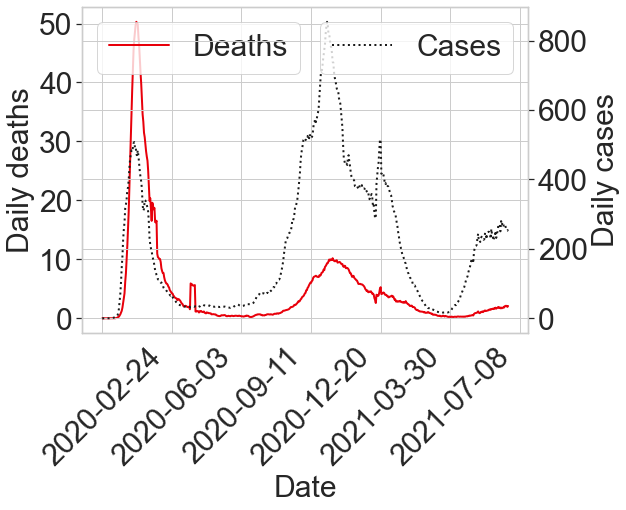

In [9]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='New York'

FONTSIZE = 30

all_death_data_pop_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
all_cases_data_pop_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

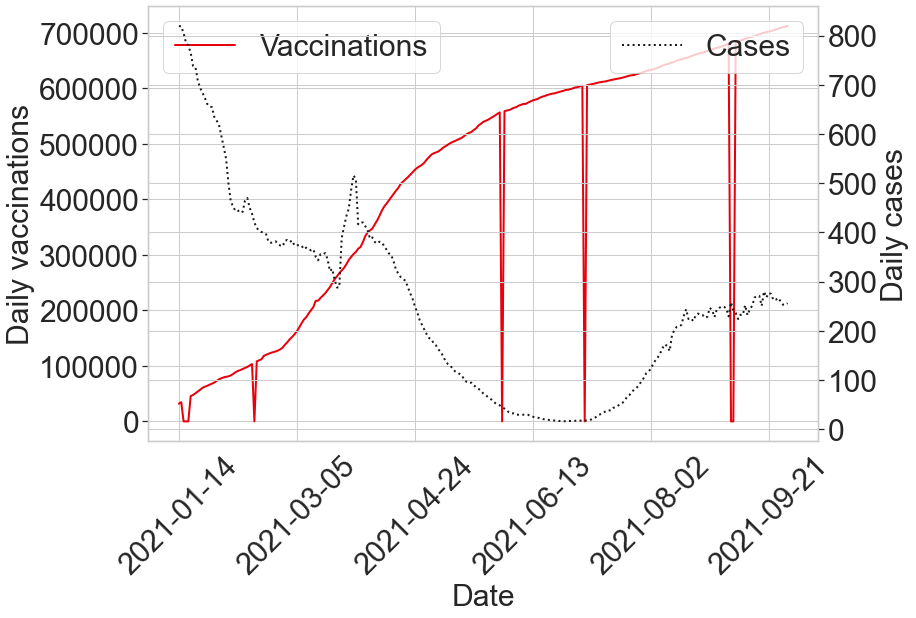

In [10]:
df1, df2 = vaccine_pop_adjusted, all_cases_data_pop_daily

idx = np.intersect1d(df1.index, df2.index)

df1 = df1.loc[idx]
df2 = df2.loc[idx]


fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='New York'

FONTSIZE = 30

df1[target].iloc[25:].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

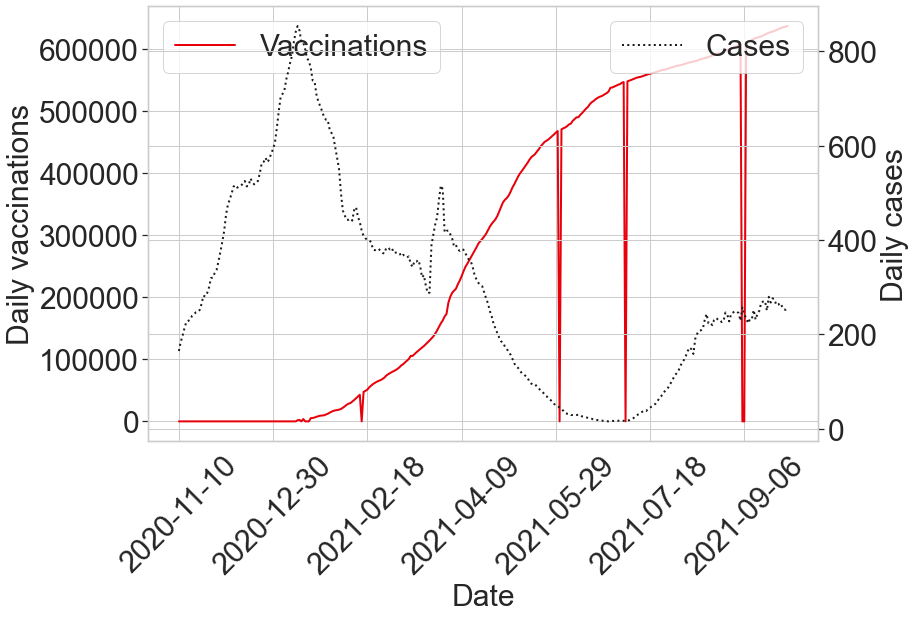

In [11]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily

df1 = df1.reindex(df2.index, fill_value=0)

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='New York'

FONTSIZE = 30

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

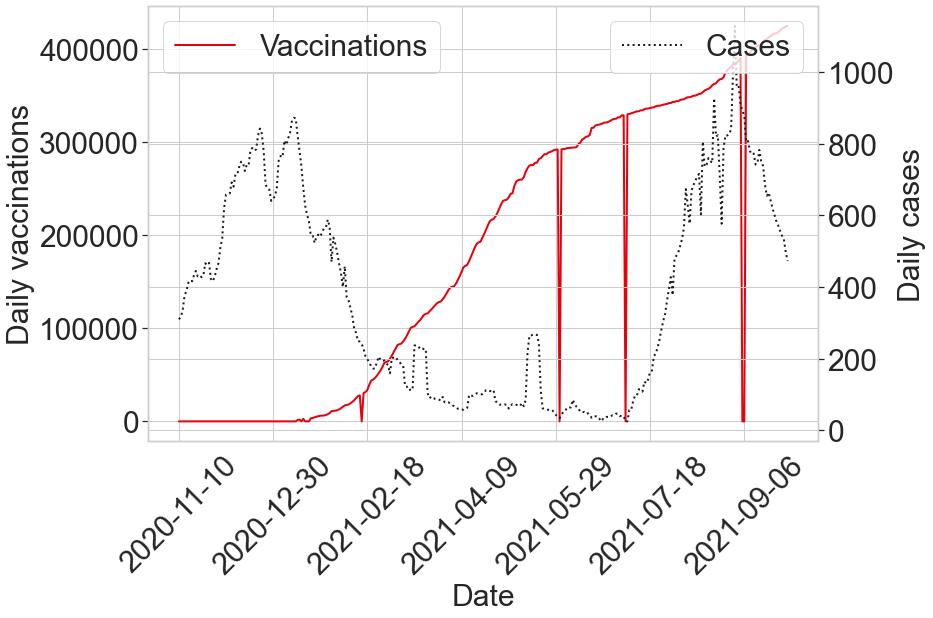

In [12]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily

df1 = df1.reindex(df2.index, fill_value=0)

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Alabama'

FONTSIZE = 30

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

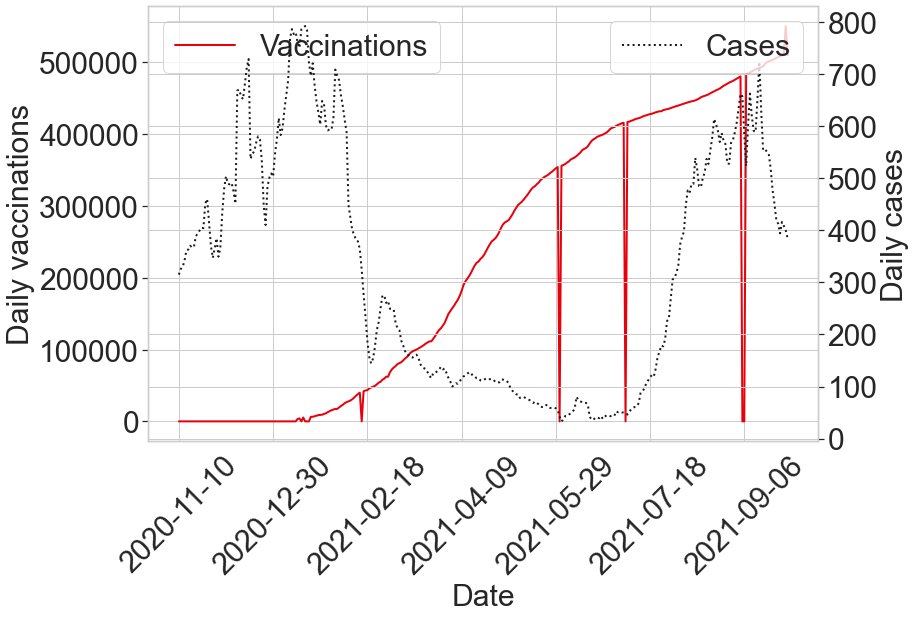

In [13]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily

df1 = df1.reindex(df2.index, fill_value=0)

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Texas'

FONTSIZE = 30

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

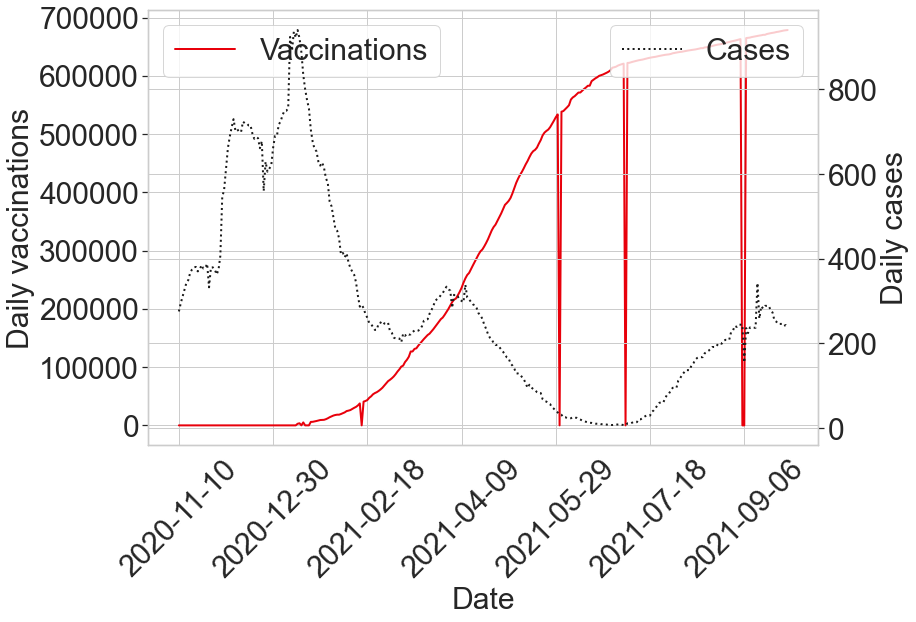

In [14]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily

df1 = df1.reindex(df2.index, fill_value=0)

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Massachusetts'

FONTSIZE = 30

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

# Counterfactual analysis

In [19]:
total = full_vaccine_pop_adjusted
total = total[set(uscases.columns).intersection(set(total.columns))]
vaccine_intervention = pd.DataFrame(total.apply(pd.Series.first_valid_index))
vaccine_intervention = vaccine_intervention.reset_index()
vaccine_intervention.columns = ["name", "date"]
total = total.fillna(0)

In [20]:
vaccine_intervention

,name,date
0,Mississippi,2020-12-20
1,North Dakota,2020-12-20
2,Indiana,2020-12-20
3,New Hampshire,2020-12-20
4,Missouri,2020-12-20
5,Maine,2020-12-20
6,South Dakota,2020-12-20
7,Utah,2020-12-20
8,Vermont,2020-12-20
9,California,2020-12-20


In [17]:
# since for all states, vaccine_intervention has the same date of 2020-12-20
vaccine_intervention.date = "2020-12-22"

In [25]:
full_vaccine_pop_adjusted.tail(1)

,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2021-09-29,424863.022709,505130.921543,511955.778026,510354.915571,455016.959352,589134.22816,593094.734678,686462.548457,576305.963252,600750.408431,...,516211.331146,453417.060394,510138.388277,505312.296668,694009.029005,605110.480101,607421.535667,403924.454858,563869.508869,415231.555794


In [30]:
tmp = full_vaccine_pop_adjusted.tail(1)
tmp>650000

,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2021-09-29,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False


In [41]:
#find a list of donors
donors = full_vaccine_pop_adjusted.tail(1)[full_vaccine_pop_adjusted.tail(1)>630000].dropna(axis = 1).columns.tolist()

In [42]:
donors

['Connecticut',
 'Guam',
 'Maine',
 'Maryland',
 'Massachusetts',
 'New Jersey',
 'New Mexico',
 'New York',
 'Puerto Rico',
 'Rhode Island',
 'Vermont']

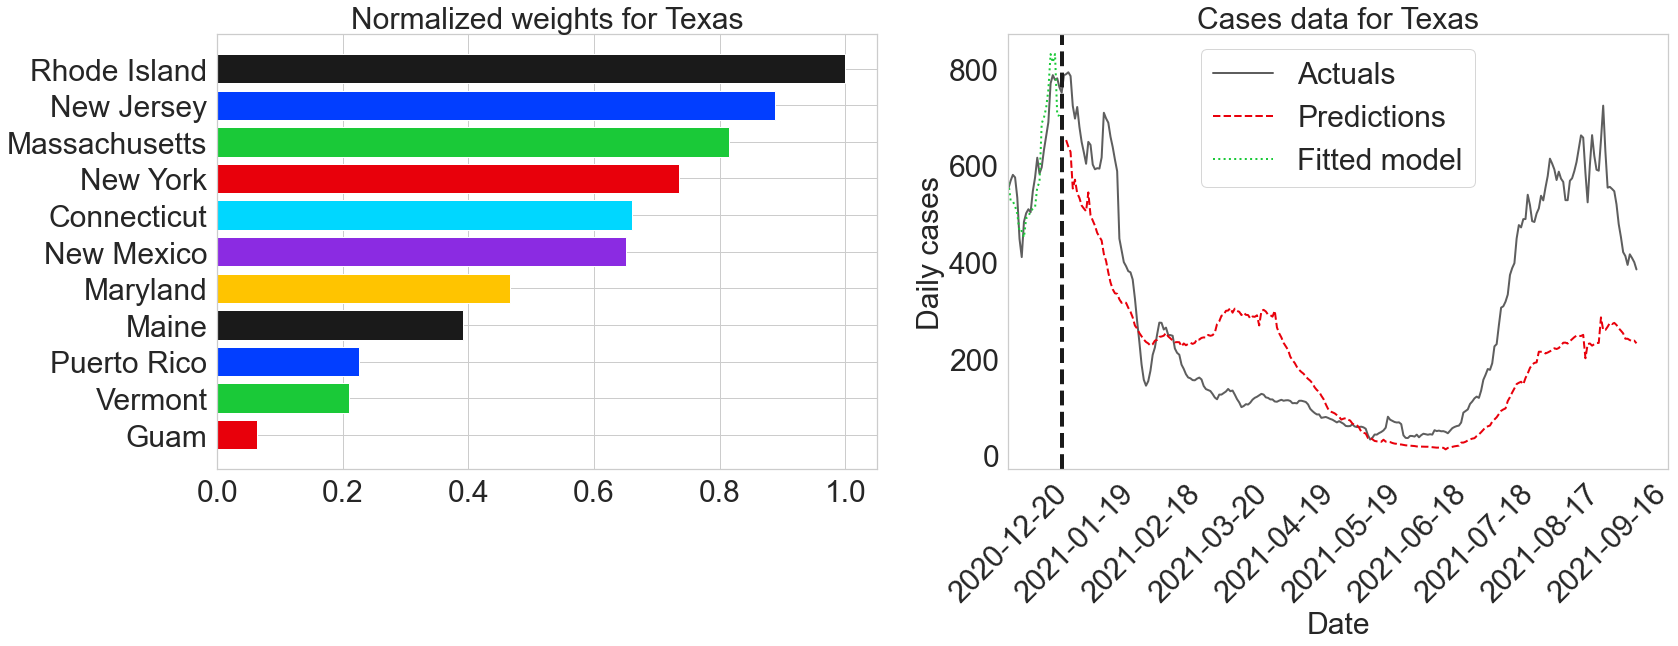

In [47]:

case_vaccine_adjusted, case_vaccine_adjusted_daily, vaccine_date_case= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)
deaths_vaccine_adjusted, deaths_vaccine_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, vaccine_intervention, 7)

target = 'Texas'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 1
lambdas = [1]
projection_period=400
training_period=25
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted_daily, deaths_vaccine_adjusted_daily],projection_period, training_period, #, xlimit=(1,200)
                                            "Cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



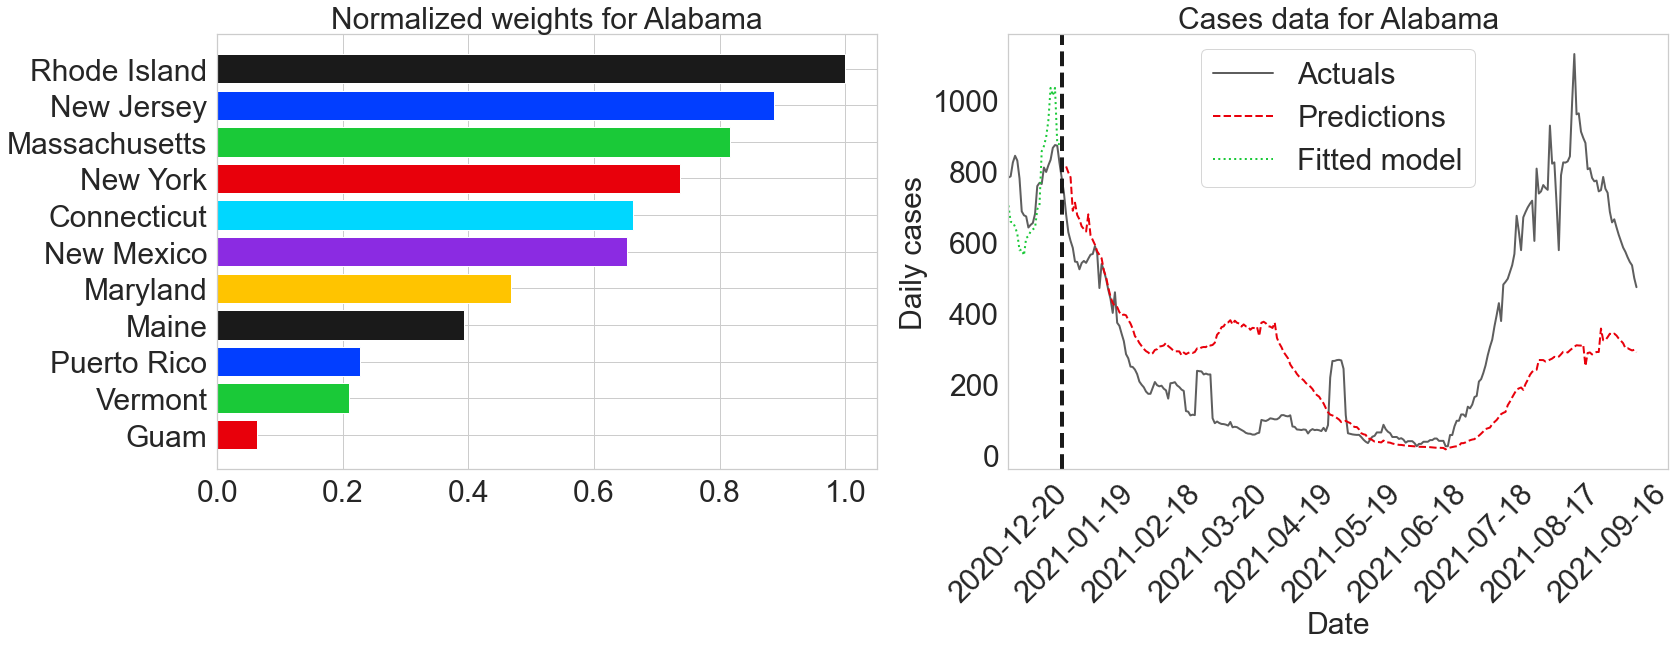

In [48]:

case_vaccine_adjusted, case_vaccine_adjusted_daily, vaccine_date_case= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)
deaths_vaccine_adjusted, deaths_vaccine_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, vaccine_intervention, 7)

target = 'Alabama'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 1
lambdas = [1]
projection_period=400
training_period=25
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted_daily, deaths_vaccine_adjusted_daily],projection_period, training_period, #, xlimit=(1,200)
                                            "Cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)

